**Module 1 :**  3_router.ipynb, 4_agent.ipynb

**Video**

[Class-03: Mastering LangGraph In a New Way: Router and Simple ReAct Agent - Nov 14, 2024 ](https://www.youtube.com/watch?v=gfESO1xI044)


# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools.

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

**rm**

**Workflow:**

Here we perform multiplication.

* First, call the tool.

* The tool's response goes to the agent/assistant/GPT.

* The agent decides what to do next: either call another tool, provide a response, or proceed to another node.


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [ ]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("GEMINI_API_KEY")

Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [ ]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

LANGCHAIN_API_KEY is use for datacollection --> double check

In [ ]:
# API Keys
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [ ]:
# Initializes a Google Generative AI language model (gemini-1.5-flash) using the provided API key.
# Google Generative AI generates text responses in conversational AI applications, such as chatbots.

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

In [ ]:
# check llm is working
result = llm.invoke("hi")
result

AIMessage(content='Hi! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-840f56f6-8cf3-4b8a-b84d-709be8dbe2fe-0', usage_metadata={'input_tokens': 2, 'output_tokens': 10, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/<your-json-key-here>"

In [ ]:
# Create tools for calculation
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: First integer
        b: Second integer
    """
    return a / b

# Define a list to store all the tools
tools = [add, multiply, divide]

# Bind tools with the language model
llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools  # get details of tool

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7bd881a3e3e0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type'

In [ ]:
# Print the representation of llm_with_tools to see its details
print(llm_with_tools)

bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7bd881a3e3e0>, default_metadata=()) kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b.', 'parameters': {'properties': {'a': {'description': 'First integer', 'type': 'integer'}, 'b': {'description': 'Second integer', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'First integer', 'type': 'integer'}, 'b': {'description': 'Second integer', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b.', 'parameters': {'properties': {'a': {'description': 'First integer', 'type

In [ ]:
# To see the methods and attributes available for llm_with_tools
print(dir(llm_with_tools))

# To check the type
print(type(llm_with_tools))


['InputType', 'OutputType', '__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '__reduce_ex__'

Let's create our LLM and prompt it with the overall desired agent behavior.

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message | Instraction in Custom GPT
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Function to create node
def assistant(state: MessagesState) -> MessagesState:
  response = llm_with_tools.invoke([sys_msg] + state["messages"])
  return {"messages": response}


In [ ]:
# above code directly call dictionary
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message | Instraction in Custom GPT
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Function to create node
def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [ ]:
sys_msg

SystemMessage(content='You are a helpful assistant tasked with performing arithmetic on a set of inputs.', additional_kwargs={}, response_metadata={})

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

In [ ]:
from langgraph.graph import START, StateGraph

from langgraph.prebuilt import tools_condition  # Determines routing to tools or end
from langgraph.prebuilt import ToolNode  # Special node for function calls

from IPython.display import Image, display  # Import IPython display classes
from langgraph.graph.state import CompiledStateGraph

# Initialize the graph builder
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)  # Pass assistant function to assistant node
builder.add_node("tools", ToolNode(tools))  # Pass tools to ToolNode, enabling function calls and responses
# Note: ToolNode(tools) now serves as both a generator and an action node. It can call the functions and respond accordingly.


# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")  # Start by calling the assistant node

# Define conditional edges: determine routing based on the result
# Define the condition: The assistant node either routes to tools via the tool-condition or routes to END.
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Route to tools if the latest message from assistant is a tool call
    # Route to END if the latest message from assistant is not a tool call
)

# Define edge: tools call assistant
builder.add_edge("tools", "assistant")  # After tools, call assistant again

# Compile the graph to a reactive graph
react_graph: CompiledStateGraph = builder.compile()


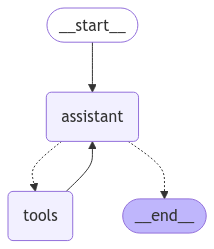

In [ ]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 4")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (09dfa1d6-5c8a-4b68-924a-cba9150775cf)
 Call ID: 09dfa1d6-5c8a-4b68-924a-cba9150775cf
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The answer is 7.


**Note:** In above error the problem is that multiple chained operations ("add", "multiply", and "divide") are being interpreted incorrectly, likely leading to premature calls to tools without resolving earlier steps as model is following <b>DMAS</b> rule here. So we will improved the prompt and try again

In [ ]:
messages = [HumanMessage(content="First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially
================================== Ai Message ==================================
Tool Calls:
  add (6ca81826-498b-4b81-abae-cadbb058e9da)
 Call ID: 6ca81826-498b-4b81-abae-cadbb058e9da
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (be1483db-7d5b-4005-b2f3-5777f9cc61bd)
 Call ID: be1483db-7d5b-4005-b2f3-5777f9cc61bd
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (7b89c32a-60ed-4a7b-8edb-c47686aefba1)
 Call ID: 7b89c32a-60ed-4a7b-8edb-c4768

## LangSmith

We can look at traces in LangSmith.